# Stochastic Tacking Point Estimation

In [12]:
import jax.numpy as jnp
from jax import Array
from jax import vmap, jit

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr
import matplotlib.cm as cm

import pickle

import os

from abc import ABC

from load_stochastic_manifold import load_stochastic_manifold

from geometry.manifolds import LorentzFinslerManifold, nEllipsoid, nSphere, T2, RiemannianNavigation, nEuclidean
from geometry.tacking import SequentialOptimizationBFGS, SequentialOptimizationADAM, GEORCE_HTacking
from geometry.geodesic import GEORCE_H, GEORCE_HStep

In [13]:
figure_path = '../figures/stochastic_tacking_estimation/'

In [14]:
plt.rcParams.update({'font.size': 25})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [15]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

In [16]:
data_path = 'tacking_gpu/stochastic/'

## Direction-Only Dependent Finsler Metrics

In [17]:
save_path = ''.join((data_path, 'direction_only/'))
    
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]

In [18]:
file_path = ''.join((save_path, onlyfiles[0]))
with open(file_path, 'rb') as f:
    curves = pickle.load(f)

In [23]:
t0, z0, zT, Malpha_expected, Mbeta_expected, tack_metrics, reverse_tack_metrics = load_stochastic_manifold("direction_only")

In [24]:
indicatrix_alpha = Malpha_expected.indicatrix(0.0, z0, N_points=100)#, grid=jnp.linspace(-5,5,1000), eps=1e-6)
indicatrix_beta = Mbeta_expected.indicatrix(0.0, z0, N_points=100)#, grid=jnp.linspace(-5,5,1000), eps=1e-6)

In [25]:
xscales = [-5.0, 5.0]
yscales = [-3.0, 9.0]

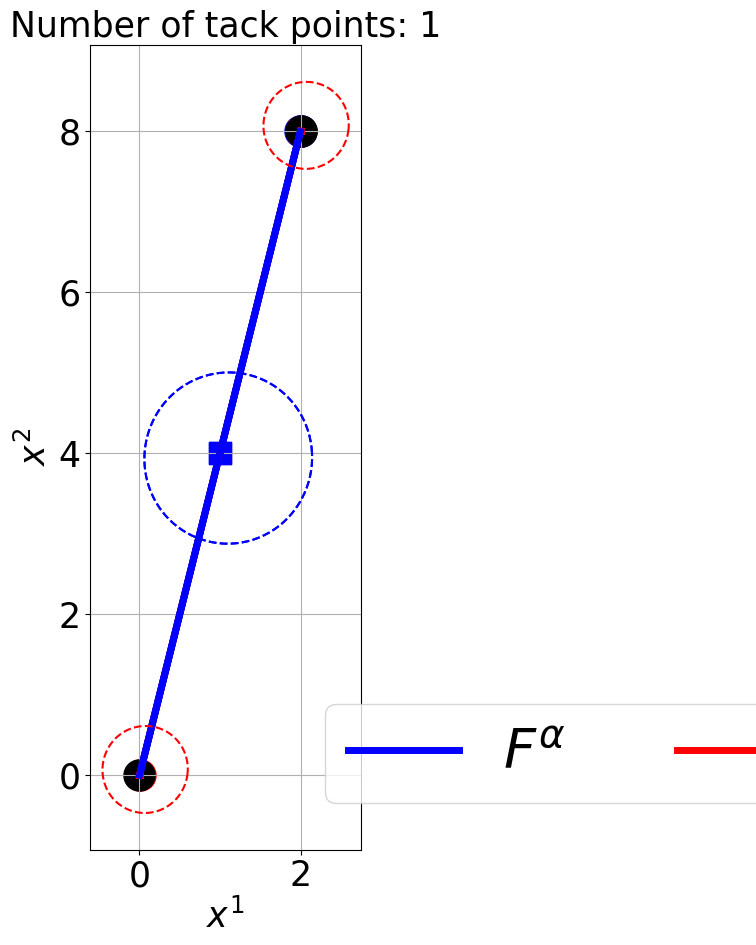

In [29]:
N_tacks = len(curves.keys())//2-1
N_tacks = 1
fig = plt.figure(figsize=((N_tacks)*10,10))

for i in range(1, N_tacks+1):
    ax = fig.add_subplot(1,N_tacks,i)
    
    #Curves with no tacking
    ax.plot(curves['ExpectedGeodesic']['zs'][:,0], curves['ExpectedGeodesic']['zs'][:,1], color='blue', linewidth=5.0, alpha=1.0)
    ax.plot(curves['ExpectedReverseGeodesic']['zs'][:,0], curves['ExpectedReverseGeodesic']['zs'][:,1], color='red', linewidth=5.0, alpha=1.0)
    
    tack_curve = curves[f'ExpectedTacking']['zs']
    reverse_tack_curve = curves[f'ExpectedReverseTacking']['zs']
    T = 1_000
    
    #Plotting curves
    for j in range(i+1):
        if j % 2 == 0:
            #Plotting Curves
            ax.plot(tack_curve[(T*j):(T*(j+1))][:,0], 
                    tack_curve[(T*j):(T*(j+1))][:,1], 
                    color="blue",
                    linewidth=5.0)
            ax.plot(reverse_tack_curve[(T*j):(T*(j+1))][:,0], 
                    reverse_tack_curve[(T*j):(T*(j+1))][:,1], 
                    color="red",
                    linewidth=5.0)
            
            #Plotting points
            ax.scatter(tack_curve[(T*(j+1))][0], 
                       tack_curve[(T*(j+1))][1],
                       color="blue",
                       s=500)
            ax.scatter(reverse_tack_curve[(T*(j+1))][0], 
                       reverse_tack_curve[(T*(j+1))][1],
                       color="red",
                       s=500)
        else:
            #Plotting Curves
            ax.plot(tack_curve[(T*j):(T*(j+1))][:,0], 
                    tack_curve[(T*j):(T*(j+1))][:,1], 
                    color="red",
                    linewidth=5.0)
            ax.plot(reverse_tack_curve[(T*j):(T*(j+1))][:,0], 
                    reverse_tack_curve[(T*j):(T*(j+1))][:,1], 
                    color="blue",
                    linewidth=5.0)
            
            #Plotting points
            ax.scatter(tack_curve[(T*(j+1))][0], 
                       tack_curve[(T*(j+1))][1],
                       color="red",
                       s=500)
            ax.scatter(reverse_tack_curve[(T*(j+1))][0], 
                       reverse_tack_curve[(T*(j+1))][1],
                       color="blue",
                       s=500)
            
    
    ## Plotting Indicatrices
    if i % 2 == 0:
        indicatrix_point_start = tack_curve[T//2]
        indicatrix_point_end = tack_curve[T*i+T//2]
        
        reverse_indicatrix_point_start = reverse_tack_curve[T//2]
        reverse_indicatrix_point_end = reverse_tack_curve[T*i+T//2]
        
        #Points
        ax.scatter(indicatrix_point_start[0], 
                   indicatrix_point_start[1], 
                   color="blue", 
                   marker='s',
                   s=250)
        ax.scatter(reverse_indicatrix_point_start[0],
                   reverse_indicatrix_point_start[1],
                   color="red", 
                   marker='s',
                   s=250)
        
        #Points
        ax.scatter(indicatrix_point_end[0], 
                   indicatrix_point_end[1], 
                   color="blue", 
                   marker='s',
                   s=250)
        ax.scatter(reverse_indicatrix_point_end[0],
                   reverse_indicatrix_point_end[1],
                   color="red", 
                   marker='s',
                   s=250)
        
        #Indicatrices
        ax.plot(indicatrix_alpha[:,0]+indicatrix_point_start[0], 
                indicatrix_alpha[:,1]+indicatrix_point_start[1], 
                color="blue", 
                linestyle='dashed')
        ax.plot(indicatrix_beta[:,0]+reverse_indicatrix_point_start[0], 
                indicatrix_beta[:,1]+reverse_indicatrix_point_start[1], 
                color="red", 
                linestyle='dashed')
        
        #Indicatrices
        ax.plot(indicatrix_alpha[:,0]+indicatrix_point_end[0], 
                indicatrix_alpha[:,1]+indicatrix_point_end[1], 
                color="blue", 
                linestyle='dashed')
        ax.plot(indicatrix_beta[:,0]+reverse_indicatrix_point_end[0], 
                indicatrix_beta[:,1]+reverse_indicatrix_point_end[1], 
                color="red", 
                linestyle='dashed')
    else:
        
        indicatrix_point_start = tack_curve[T//2]
        indicatrix_point_end = tack_curve[T*i+T//2]
        
        reverse_indicatrix_point_start = reverse_tack_curve[T//2]
        reverse_indicatrix_point_end = reverse_tack_curve[T*i+T//2]
        
        #Points
        ax.scatter(indicatrix_point_start[0], 
                   indicatrix_point_start[1], 
                   color="blue", 
                   marker='s',
                   s=250)
        ax.scatter(reverse_indicatrix_point_start[0],
                   reverse_indicatrix_point_start[1],
                   color="red", 
                   marker='s',
                   s=250)
        
        #Points
        ax.scatter(indicatrix_point_end[0], 
                   indicatrix_point_end[1], 
                   color="red", 
                   marker='s',
                   s=250)
        ax.scatter(reverse_indicatrix_point_end[0],
                   reverse_indicatrix_point_end[1],
                   color="blue", 
                   marker='s',
                   s=250)
        
        #Indicatrices
        ax.plot(indicatrix_alpha[:,0]+indicatrix_point_start[0], 
                indicatrix_alpha[:,1]+indicatrix_point_start[1], 
                color="blue", 
                linestyle='dashed')
        ax.plot(indicatrix_beta[:,0]+reverse_indicatrix_point_start[0], 
                indicatrix_beta[:,1]+reverse_indicatrix_point_start[1], 
                color="red", 
                linestyle='dashed')
        
        #Indicatrices
        ax.plot(indicatrix_beta[:,0]+indicatrix_point_end[0], 
                indicatrix_beta[:,1]+indicatrix_point_end[1], 
                color="red", 
                linestyle='dashed')
        ax.plot(indicatrix_alpha[:,0]+reverse_indicatrix_point_end[0], 
                indicatrix_alpha[:,1]+reverse_indicatrix_point_end[1], 
                color="blue", 
                linestyle='dashed')
        
        
            
    ax.set_xlabel(r'$x^{1}$', fontsize=25)
    ax.set_ylabel(r'$x^{2}$', fontsize=25)
    ax.set_title(f"Number of tack points: {i}", fontsize=25)
    ax.grid(True)
    #ax.set_xlim(xscales[0], xscales[1])
    #ax.set_ylim(yscales[0], yscales[1])
    ax.set_aspect('equal', adjustable='box')
    
    #Start and end point
    ax.scatter(z0[0], z0[1], color="black", s=500)
    ax.scatter(zT[0], zT[1], color="black", s=500)

ax.plot([0],[0], color="blue", label=r'$F^{\alpha}$', linewidth=5.0)
ax.plot([0],[0], color="red", label=r'$F^{\beta}$', linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.43,0.15), ncol=2, fontsize=40)
    
fig.tight_layout()

save_path = f'{figure_path}direction_only.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')
    
plt.show()


## Time-Only Dependent Finsler Metrics

In [100]:
save_path = ''.join((data_path, 'time_only/'))
    
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]

In [101]:
file_path = ''.join((save_path, onlyfiles[0]))
with open(file_path, 'rb') as f:
    curves = pickle.load(f)

In [102]:
t0, z0, zT, tack_metrics, reverse_tack_metrics = load_manifold("time_only")

In [106]:
indicatrix_alpha = tack_metrics[0].indicatrix(t0, z0, N_points=100)#grid=jnp.linspace(-5,5,1000), eps=1e-6)
indicatrix_beta = reverse_tack_metrics[0].indicatrix(curves['Tacking_1']['travel_time'], zT, N_points=100)#grid=jnp.linspace(-20,20,10000), eps=1e-6)

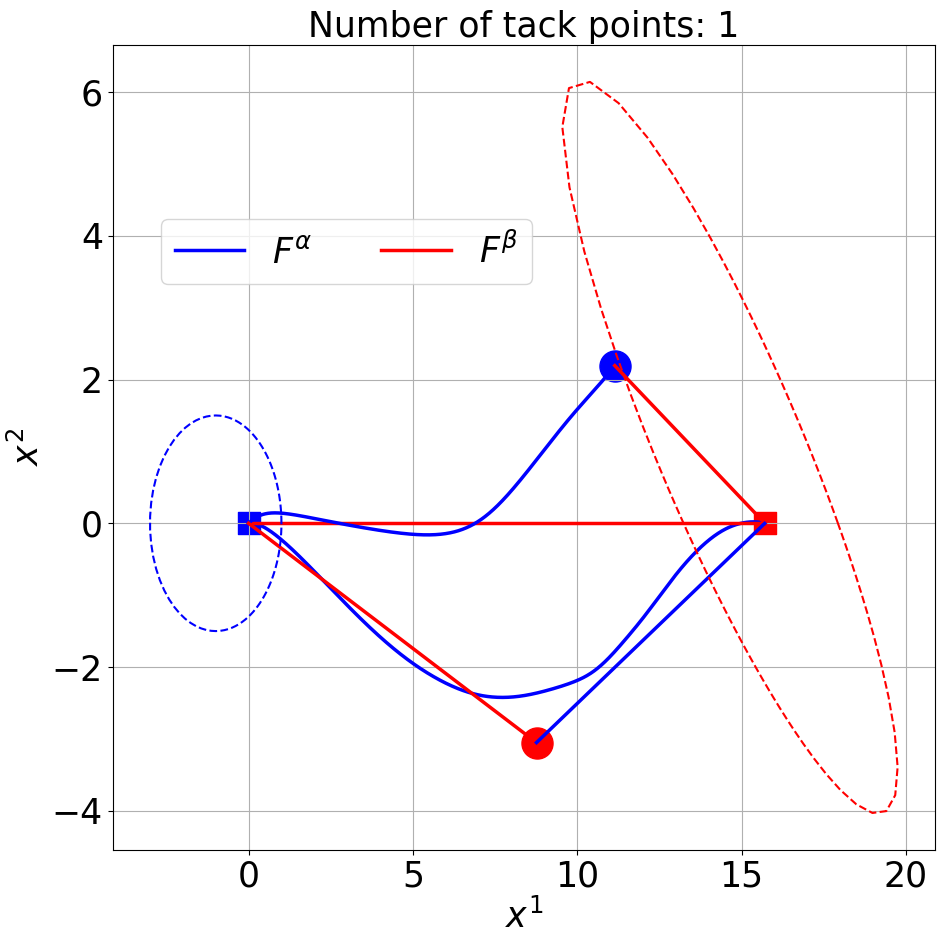

In [111]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

#Curves with no tacking
ax.plot(curves['Geodesic']['zs'][:,0], curves['Geodesic']['zs'][:,1], color='blue', linewidth=2.5, alpha=1.0)
ax.plot(curves['ReverseGeodesic']['zs'][:,0], curves['ReverseGeodesic']['zs'][:,1], color='red', linewidth=2.5, alpha=1.0)

#Plotting tack curves
for j in range(2):
    
    tack_curve = curves['Tacking_1']['zs']
    reverse_tack_curve = curves['ReverseTacking_1']['zs']
    
    if j % 2 == 0:
        #Plotting Curves
        ax.plot(tack_curve[(T*j):(T*(j+1))][:,0], 
                tack_curve[(T*j):(T*(j+1))][:,1], 
                color="blue",
                linewidth=2.5)
        ax.plot(reverse_tack_curve[(T*j):(T*(j+1))][:,0], 
                reverse_tack_curve[(T*j):(T*(j+1))][:,1], 
                color="red",
                linewidth=2.5)

        #Plotting points
        ax.scatter(tack_curve[(T*(j+1))][0], 
                   tack_curve[(T*(j+1))][1],
                   color="blue",
                   s=500)
        ax.scatter(reverse_tack_curve[(T*(j+1))][0], 
                   reverse_tack_curve[(T*(j+1))][1],
                   color="red",
                   s=500)
    else:
        #Plotting Curves
        ax.plot(tack_curve[(T*j):(T*(j+1))][:,0], 
                tack_curve[(T*j):(T*(j+1))][:,1], 
                color="red",
                linewidth=2.5)
        ax.plot(reverse_tack_curve[(T*j):(T*(j+1))][:,0], 
                reverse_tack_curve[(T*j):(T*(j+1))][:,1], 
                color="blue",
                linewidth=2.5)
        
#Indicatrices
ax.plot(indicatrix_alpha[:,0]+z0[0], 
        indicatrix_alpha[:,1]+z0[1], 
        color="blue", 
        linestyle='dashed')

#Indicatrices
ax.plot(indicatrix_beta[:,0]+zT[0], 
        indicatrix_beta[:,1]+zT[1], 
        color="red", 
        linestyle='dashed')

ax.set_xlabel(r'$x^{1}$', fontsize=25)
ax.set_ylabel(r'$x^{2}$', fontsize=25)
ax.set_title("Number of tack points: 1", fontsize=25)
ax.grid(True)
#ax.set_xlim(xscales[0], xscales[1])
#ax.set_ylim(yscales[0], yscales[1])
#ax.set_aspect('equal', adjustable='box')

ax.plot([0],[0], color="blue", label=r'$F^{\alpha}$', linewidth=2.5)
ax.plot([0],[0], color="red", label=r'$F^{\beta}$', linewidth=2.5)

#Start and end point
ax.scatter(z0[0], z0[1], marker="s", color="blue", s=250)
ax.scatter(zT[0], zT[1], marker="s", color="red", s=250)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.17,0.7), ncol=2, fontsize=25)
    
fig.tight_layout()

save_path = f'{figure_path}time_only.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')
    
plt.show()

## Poincarre

In [112]:
save_path = ''.join((data_path, 'poincarre/'))
    
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]

In [113]:
file_path = ''.join((save_path, onlyfiles[0]))
with open(file_path, 'rb') as f:
    curves = pickle.load(f)

In [114]:
t0, z0, zT, tack_metrics, reverse_tack_metrics = load_manifold("poincarre")

In [122]:
indicatrix_alpha = tack_metrics[0].indicatrix(0.0, z0, N_points=100)#, grid=jnp.linspace(-5,5,1000), eps=1e-6)
indicatrix_beta = reverse_tack_metrics[0].indicatrix(0.0, z0, N_points=100)#, grid=jnp.linspace(-5,5,1000), eps=1e-6)

In [123]:
xscales = [-1.0, 12.0]
yscales = [-1.0, 6.0]

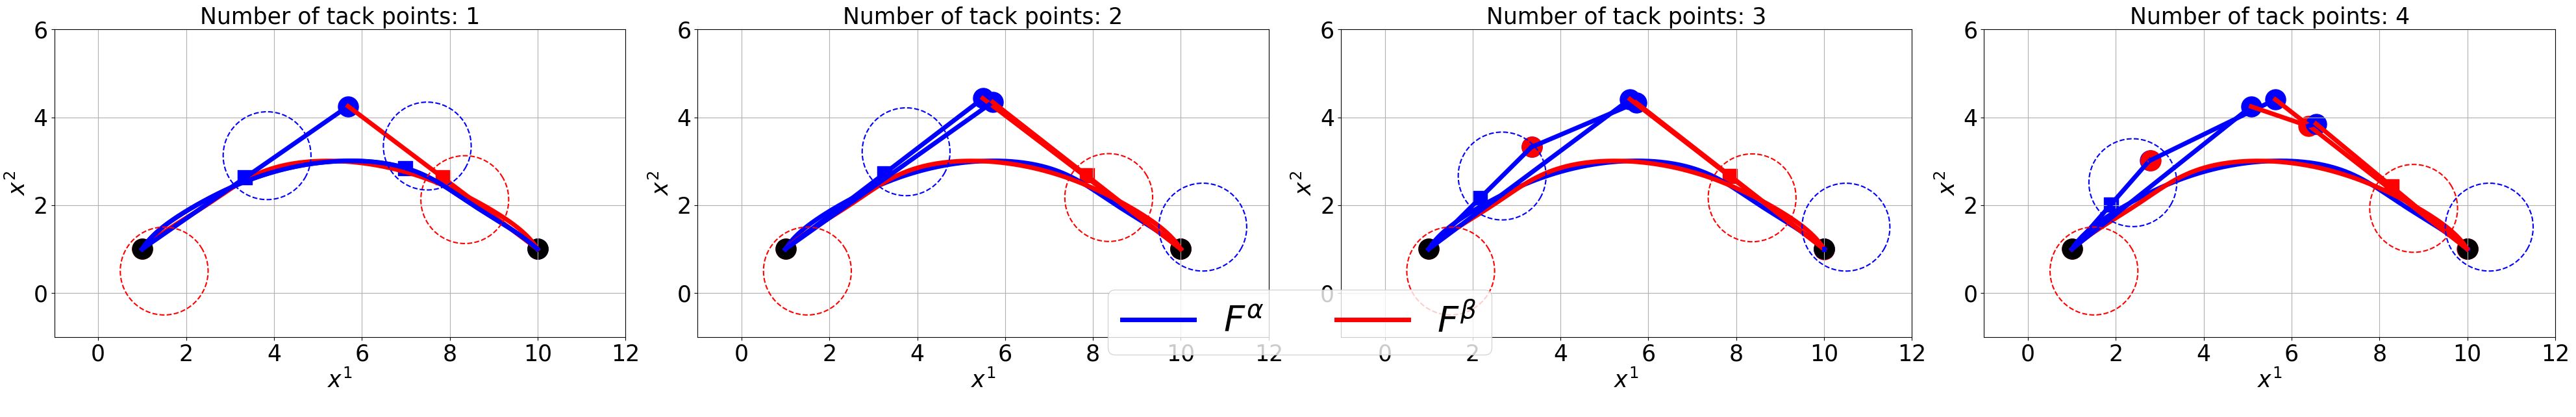

In [124]:
N_tacks = len(curves.keys())//2-1

fig = plt.figure(figsize=((N_tacks)*10,10))

for i in range(1, N_tacks+1):
    ax = fig.add_subplot(1,N_tacks,i)
    
    #Curves with no tacking
    ax.plot(curves['Geodesic']['zs'][:,0], curves['Geodesic']['zs'][:,1], color='blue', linewidth=5.0, alpha=1.0)
    ax.plot(curves['ReverseGeodesic']['zs'][:,0], curves['ReverseGeodesic']['zs'][:,1], color='red', linewidth=5.0, alpha=1.0)
    
    tack_curve = curves[f'Tacking_{i}']['zs']
    reverse_tack_curve = curves[f'ReverseTacking_{i}']['zs']
    
    #Plotting curves
    for j in range(i+1):
        if j % 2 == 0:
            #Plotting Curves
            ax.plot(tack_curve[(T*j):(T*(j+1))][:,0], 
                    tack_curve[(T*j):(T*(j+1))][:,1], 
                    color="blue",
                    linewidth=5.0)
            ax.plot(reverse_tack_curve[(T*j):(T*(j+1))][:,0], 
                    reverse_tack_curve[(T*j):(T*(j+1))][:,1], 
                    color="red",
                    linewidth=5.0)
            
            #Plotting points
            ax.scatter(tack_curve[(T*(j+1))][0], 
                       tack_curve[(T*(j+1))][1],
                       color="blue",
                       s=500)
            ax.scatter(reverse_tack_curve[(T*(j+1))][0], 
                       reverse_tack_curve[(T*(j+1))][1],
                       color="red",
                       s=500)
        else:
            #Plotting Curves
            ax.plot(tack_curve[(T*j):(T*(j+1))][:,0], 
                    tack_curve[(T*j):(T*(j+1))][:,1], 
                    color="red",
                    linewidth=5.0)
            ax.plot(reverse_tack_curve[(T*j):(T*(j+1))][:,0], 
                    reverse_tack_curve[(T*j):(T*(j+1))][:,1], 
                    color="blue",
                    linewidth=5.0)
            
            #Plotting points
            ax.scatter(tack_curve[(T*(j+1))][0], 
                       tack_curve[(T*(j+1))][1],
                       color="red",
                       s=500)
            ax.scatter(reverse_tack_curve[(T*(j+1))][0], 
                       reverse_tack_curve[(T*(j+1))][1],
                       color="blue",
                       s=500)
            
    
    ## Plotting Indicatrices
    if i % 2 == 0:
        indicatrix_point_start = tack_curve[T//2]
        indicatrix_point_end = tack_curve[T*i+T//2]
        
        reverse_indicatrix_point_start = reverse_tack_curve[T//2]
        reverse_indicatrix_point_end = reverse_tack_curve[T*i+T//2]
        
        #Points
        ax.scatter(indicatrix_point_start[0], 
                   indicatrix_point_start[1], 
                   color="blue", 
                   marker='s',
                   s=250)
        ax.scatter(reverse_indicatrix_point_start[0],
                   reverse_indicatrix_point_start[1],
                   color="red", 
                   marker='s',
                   s=250)
        
        #Points
        ax.scatter(indicatrix_point_end[0], 
                   indicatrix_point_end[1], 
                   color="blue", 
                   marker='s',
                   s=250)
        ax.scatter(reverse_indicatrix_point_end[0],
                   reverse_indicatrix_point_end[1],
                   color="red", 
                   marker='s',
                   s=250)
        
        #Indicatrices
        ax.plot(indicatrix_alpha[:,0]+indicatrix_point_start[0], 
                indicatrix_alpha[:,1]+indicatrix_point_start[1], 
                color="blue", 
                linestyle='dashed')
        ax.plot(indicatrix_beta[:,0]+reverse_indicatrix_point_start[0], 
                indicatrix_beta[:,1]+reverse_indicatrix_point_start[1], 
                color="red", 
                linestyle='dashed')
        
        #Indicatrices
        ax.plot(indicatrix_alpha[:,0]+indicatrix_point_end[0], 
                indicatrix_alpha[:,1]+indicatrix_point_end[1], 
                color="blue", 
                linestyle='dashed')
        ax.plot(indicatrix_beta[:,0]+reverse_indicatrix_point_end[0], 
                indicatrix_beta[:,1]+reverse_indicatrix_point_end[1], 
                color="red", 
                linestyle='dashed')
    else:
        
        indicatrix_point_start = tack_curve[T//2]
        indicatrix_point_end = tack_curve[T*i+T//2]
        
        reverse_indicatrix_point_start = reverse_tack_curve[T//2]
        reverse_indicatrix_point_end = reverse_tack_curve[T*i+T//2]
        
        #Points
        ax.scatter(indicatrix_point_start[0], 
                   indicatrix_point_start[1], 
                   color="blue", 
                   marker='s',
                   s=250)
        ax.scatter(reverse_indicatrix_point_start[0],
                   reverse_indicatrix_point_start[1],
                   color="red", 
                   marker='s',
                   s=250)
        
        #Points
        ax.scatter(indicatrix_point_end[0], 
                   indicatrix_point_end[1], 
                   color="red", 
                   marker='s',
                   s=250)
        ax.scatter(reverse_indicatrix_point_end[0],
                   reverse_indicatrix_point_end[1],
                   color="blue", 
                   marker='s',
                   s=250)
        
        #Indicatrices
        ax.plot(indicatrix_alpha[:,0]+indicatrix_point_start[0], 
                indicatrix_alpha[:,1]+indicatrix_point_start[1], 
                color="blue", 
                linestyle='dashed')
        ax.plot(indicatrix_beta[:,0]+reverse_indicatrix_point_start[0], 
                indicatrix_beta[:,1]+reverse_indicatrix_point_start[1], 
                color="red", 
                linestyle='dashed')
        
        #Indicatrices
        ax.plot(indicatrix_beta[:,0]+indicatrix_point_end[0], 
                indicatrix_beta[:,1]+indicatrix_point_end[1], 
                color="red", 
                linestyle='dashed')
        ax.plot(indicatrix_alpha[:,0]+reverse_indicatrix_point_end[0], 
                indicatrix_alpha[:,1]+reverse_indicatrix_point_end[1], 
                color="blue", 
                linestyle='dashed')
        
        
            
    ax.set_xlabel(r'$x^{1}$', fontsize=25)
    ax.set_ylabel(r'$x^{2}$', fontsize=25)
    ax.set_title(f"Number of tack points: {i}", fontsize=25)
    ax.grid(True)
    ax.set_xlim(xscales[0], xscales[1])
    ax.set_ylim(yscales[0], yscales[1])
    ax.set_aspect('equal', adjustable='box')
    
    #Start and end point
    ax.scatter(z0[0], z0[1], color="black", s=500)
    ax.scatter(zT[0], zT[1], color="black", s=500)

ax.plot([0],[0], color="blue", label=r'$F^{\alpha}$', linewidth=5.0)
ax.plot([0],[0], color="red", label=r'$F^{\beta}$', linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.43,0.15), ncol=2, fontsize=40)
    
fig.tight_layout()

save_path = f'{figure_path}poincarre.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')
    
plt.show()
